## Construcción del conjunto de datos

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import pathlib
import numpy as np
import pandas as pd
from torchvision.models.detection.transform import GeneralizedRCNNTransform

from datasets import ObjectDetectionDataSet
from transformations import Clip, ComposeDouble, FunctionWrapperDouble, normalize_01
from utils import get_filenames_of_path, stats_dataset, read_json
from visual import DatasetViewer

In [3]:
# Directorio de las imagenes y las etiquetas
root = pathlib.Path('../data/ChestXRay8')

In [4]:
# Cargar imágenes y etiquetas
inputs = get_filenames_of_path(root / 'ChestBBImages')
targets = get_filenames_of_path(root / 'ChestBBLabels')

inputs.sort()
targets.sort()

In [5]:
# Mapeo de etiquetas a valores enteros
mapping = read_json(pathlib.Path('LabelsMappping.json'))
mapping

{'Infiltrate': 0,
 'Atelectasis': 1,
 'Pneumonia': 2,
 'Cardiomegaly': 3,
 'Effusion': 4,
 'Pneumothorax': 5,
 'Mass': 6,
 'Nodule': 7}

In [6]:
# Transformaciones, ajustar formato, normalizar a m: 0 y std: 1
transforms = ComposeDouble([
    Clip(),
    # AlbumentationWrapper(albumentation=A.HorizontalFlip(p=0.5)),
    # AlbumentationWrapper(albumentation=A.RandomScale(p=0.5, scale_limit=0.5)),
    # AlbumentationWrapper(albumentation=A.VerticalFlip(p=0.5)),
    FunctionWrapperDouble(np.moveaxis, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

In [7]:
# Contruir el Conjunto de Datos
dataset = ObjectDetectionDataSet(inputs=inputs,
                                 targets=targets,
                                 transform=transforms,
                                 add_dim = True,
                                 use_cache=False,
                                 convert_to_format=None,
                                 mapping=mapping,
                                 tgt_int64=True)

In [8]:
# Visualizar el conjunto de datos con las etiquetas (Cajas delimitadoras)
# (Navegar entre imagenes en el visor de imagenes Napari(ventana externa) con las teclas 'n' y 'b')
colors = ['red','blue','black','purple','yellow','green','#aaffff','orange']
color_mapping = {v:colors[i] for i,v in enumerate(mapping.values())}

datasetviewer = DatasetViewer(dataset, color_mapping)
datasetviewer.napari()
datasetviewer.gui_text_properties(datasetviewer.shape_layer)

### Ejemplo de visualizacion de imagenes con etiquetas
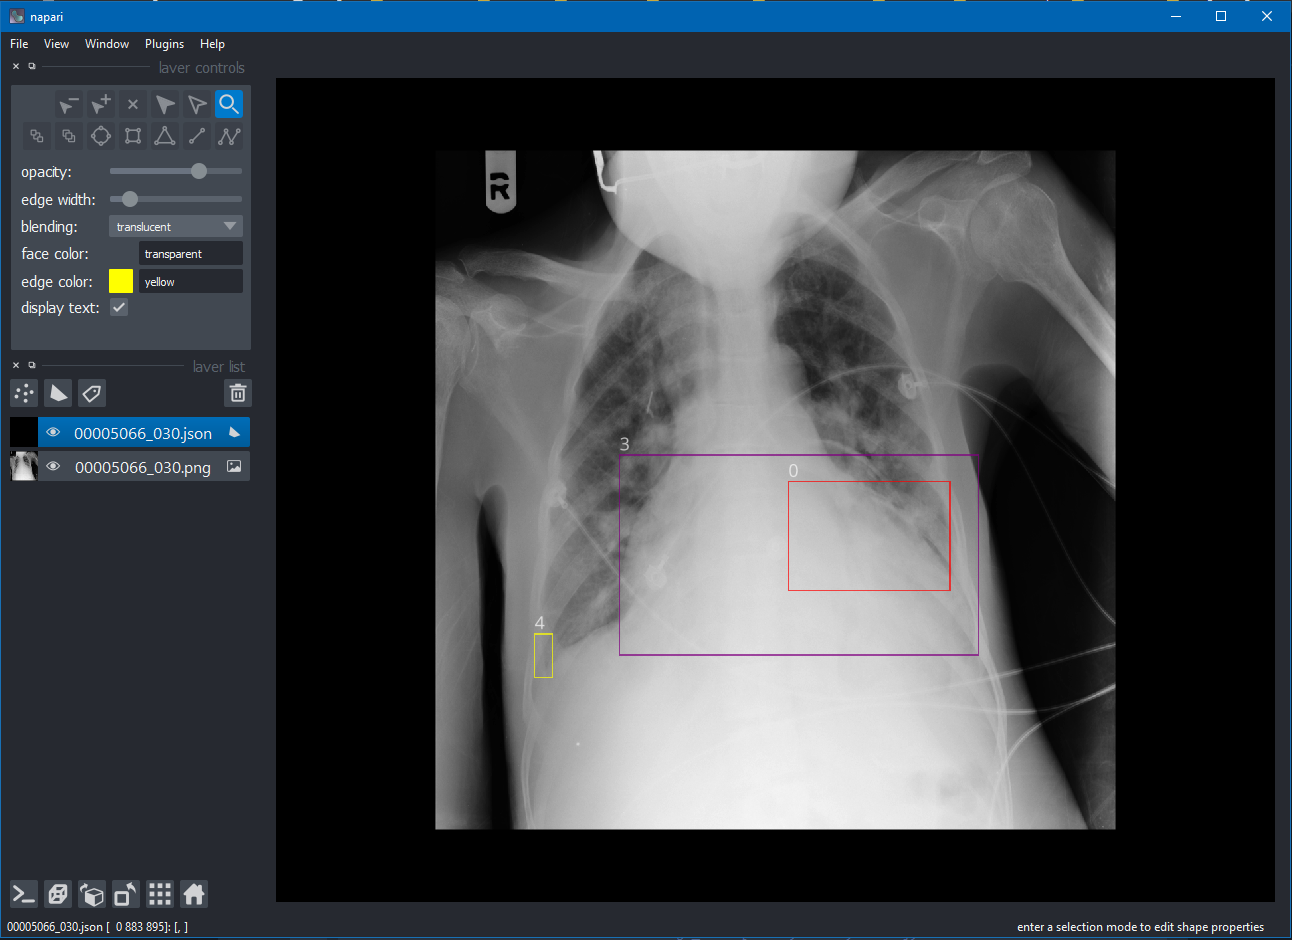

In [9]:
# Visualizar el conjunto de datos con las transformciones para Faster-RCNN
# (Navegar entre imagenes en el visor de imagenes Napari(ventana externa) con las teclas 'n' y 'b')
colors = ['red','blue','black','purple','yellow','green','#aaffff','orange']
color_mapping = {v:colors[i] for i,v in enumerate(mapping.values())}

transform = GeneralizedRCNNTransform(min_size=1024,
                                     max_size=1024,
                                     image_mean=[0.485, 0.456, 0.406],# Medias ImageNet
                                     image_std=[0.229, 0.224, 0.225]) # Desviaciones Estándar ImageNet

datasetviewer = DatasetViewer(dataset, color_mapping, rccn_transform=transform)
datasetviewer.napari()

#### Ejemplo de visualizacion de imágenes etiquetadas y transformaciones de FRCNN
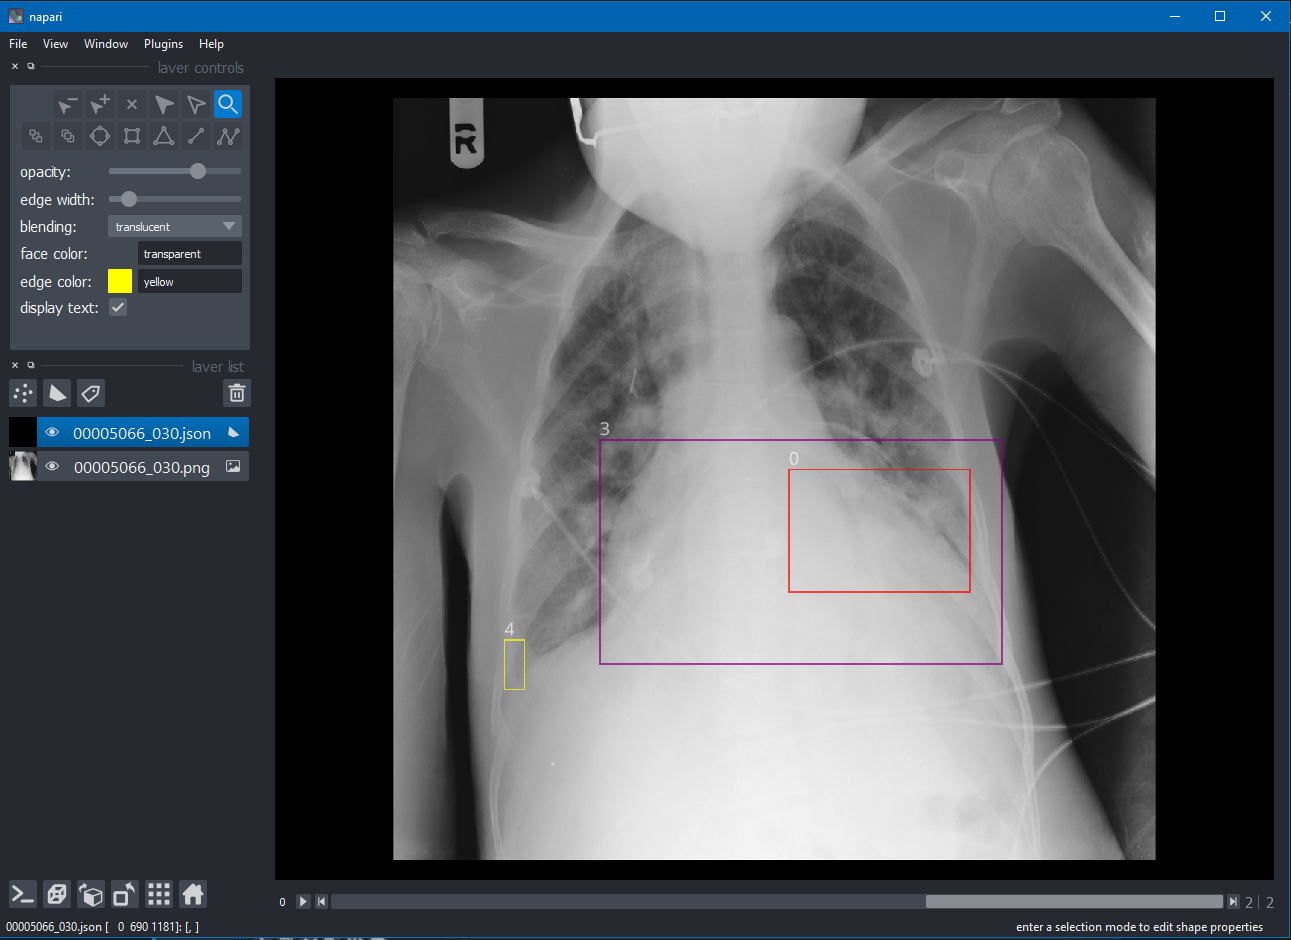

## Obtener Estadísticas del Conjunto de datos

In [10]:
stats = stats_dataset(dataset)

transform = GeneralizedRCNNTransform(min_size=1024,
                                     max_size=1024,
                                     image_mean=[0.485, 0.456, 0.406],
                                     image_std=[0.229, 0.224, 0.225])
stats_transform = stats_dataset(dataset, transform)


stats_comparison = pd.DataFrame({'Image Height':[stats['image_height'].max(),stats_transform['image_height'].max()],
                                 'Image Width':[stats['image_width'].max(),stats_transform['image_width'].max()],
                                 'Image Mean':[stats['image_mean'].max(),stats_transform['image_mean'].max()],
                                 'Image Std':[stats['image_std'].max(),stats_transform['image_std'].max()],
                                 'Boxes Height':[stats['boxes_height'].max(),stats_transform['boxes_height'].max()],
                                 'Boxes Width':[stats['boxes_width'].max(),stats_transform['boxes_width'].max()],
                                 'Boxes Num':[stats['boxes_num'].max(),stats_transform['boxes_num'].max()],
                                 'Boxes Area':[stats['boxes_area'].max(),stats_transform['boxes_area'].max()]}, index = ['    Without Trsfms Max Val', '    With Trsfms Max Val'])

print(stats_comparison.T)

                 Without Trsfms Max Val     With Trsfms Max Val
Image Height              tensor(1024.)           tensor(1024.)
Image Width               tensor(1024.)           tensor(1024.)
Image Mean               tensor(0.8986)          tensor(1.9905)
Image Std                tensor(0.3401)          tensor(1.5117)
Boxes Height                tensor(901)            tensor(901.)
Boxes Width                 tensor(873)            tensor(873.)
Boxes Num                    tensor(4.)              tensor(4.)
Boxes Area               tensor(583731)         tensor(583731.)
